# AnnoMI Deep Analysis - Filtered & Enhanced

This notebook performs advanced analysis on the AnnoMI cognitive action predictions, with improvements:

**Key Features:**
- ✅ Filter out short utterances (< 10 characters) to remove noise ("hmm", "uh-huh", etc.)
- ✅ Enhanced cognitive pattern analysis
- ✅ Co-occurrence analysis (which cognitive actions appear together)
- ✅ Sequential pattern analysis (what follows what in conversations)
- ✅ MI quality correlation (high vs low quality sessions)
- ✅ Therapist behavior breakdown by cognitive actions
- ✅ Advanced visualizations

**Requirements:**
- Pre-computed predictions from `all_predictions.json`

## 1️⃣ Setup and Data Loading

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("✅ Libraries loaded")

✅ Libraries loaded


In [2]:
# Load predictions
predictions_path = 'output/analysis_AnnoMI/all_predictions.json'

print("📥 Loading predictions...")
with open(predictions_path, 'r') as f:
    all_predictions = json.load(f)

print(f"✅ Loaded {len(all_predictions)} predictions")

# Create DataFrame for easier analysis
df = pd.DataFrame(all_predictions)

print(f"\n📊 Dataset Overview:")
print(f"   Total utterances: {len(df)}")
print(f"   Transcripts: {df['transcript_id'].nunique()}")
print(f"   Topics: {df['topic'].nunique()}")
print(f"   Therapist utterances: {len(df[df['interlocutor'] == 'therapist'])}")
print(f"   Client utterances: {len(df[df['interlocutor'] == 'client'])}")

📥 Loading predictions...
✅ Loaded 9699 predictions

📊 Dataset Overview:
   Total utterances: 9699
   Transcripts: 133
   Topics: 44
   Therapist utterances: 4882
   Client utterances: 4817


## 1️⃣.1 Filter High-Confidence Cognitive Actions

Filter predictions to keep only cognitive actions that:
- Appear on **more than 2 layers**, OR
- Have **100% confidence score**

This removes noise and focuses on robust cognitive action detections.

In [3]:
print("🔍 Filtering cognitive actions for high confidence...")
print(f"   Total predictions before filtering: {len(all_predictions)}")

# Filter each prediction to keep only high-confidence actions
filtered_predictions_list = []

for pred_data in all_predictions:
    action_layer_details = pred_data.get('action_layer_details', {})
    predictions = pred_data['predictions']
    
    # Create filtered predictions dict
    filtered_predictions = {}
    
    for action_name, action_info in predictions.items():
        if not action_info.get('is_active', False):
            continue
        
        # Check filtering criteria
        num_layers = len(action_layer_details.get(action_name, []))
        max_confidence = max([layer_info['confidence'] for layer_info in action_layer_details.get(action_name, [])], default=0)
        
        # Keep if: appears on >2 layers OR has 100% confidence
        if num_layers > 2 or max_confidence >= 1.0:
            filtered_predictions[action_name] = action_info
    
    # Create filtered prediction entry
    filtered_pred_data = pred_data.copy()
    filtered_pred_data['predictions'] = filtered_predictions
    filtered_predictions_list.append(filtered_pred_data)

# Count statistics
total_actions_before = sum(len([a for a, d in pred['predictions'].items() if d.get('is_active', False)]) 
                          for pred in all_predictions)
total_actions_after = sum(len([a for a, d in pred['predictions'].items() if d.get('is_active', False)]) 
                         for pred in filtered_predictions_list)

print(f"   Total predictions after filtering: {len(filtered_predictions_list)}")
print(f"   Active actions before: {total_actions_before}")
print(f"   Active actions after: {total_actions_after}")
print(f"   Removed: {total_actions_before - total_actions_after} actions ({(total_actions_before - total_actions_after)/total_actions_before*100:.1f}%)")

# Replace all_predictions with filtered version
all_predictions = filtered_predictions_list

# Recreate the DataFrame with filtered data
df = pd.DataFrame(all_predictions)

print(f"✅ Filtering complete! Using {len(all_predictions)} filtered predictions for all analyses.")

🔍 Filtering cognitive actions for high confidence...
   Total predictions before filtering: 9699
   Total predictions after filtering: 9699
   Active actions before: 62355
   Active actions after: 40228
   Removed: 22127 actions (35.5%)
✅ Filtering complete! Using 9699 filtered predictions for all analyses.


## 2️⃣ Data Cleaning - Filter Short Utterances

In [4]:
# Calculate utterance lengths
df['utterance_length'] = df['utterance_text'].str.len()

print("📏 Utterance Length Distribution:")
print(f"   Mean length: {df['utterance_length'].mean():.1f} characters")
print(f"   Median length: {df['utterance_length'].median():.1f} characters")
print(f"   Min length: {df['utterance_length'].min()} characters")
print(f"   Max length: {df['utterance_length'].max()} characters")

# Show distribution
print("\n📊 Length distribution:")
print(f"   < 10 chars: {len(df[df['utterance_length'] < 10])} ({len(df[df['utterance_length'] < 10])/len(df)*100:.1f}%)")
print(f"   10-50 chars: {len(df[(df['utterance_length'] >= 10) & (df['utterance_length'] < 50)])} ({len(df[(df['utterance_length'] >= 10) & (df['utterance_length'] < 50)])/len(df)*100:.1f}%)")
print(f"   50-100 chars: {len(df[(df['utterance_length'] >= 50) & (df['utterance_length'] < 100)])} ({len(df[(df['utterance_length'] >= 50) & (df['utterance_length'] < 100)])/len(df)*100:.1f}%)")
print(f"   100+ chars: {len(df[df['utterance_length'] >= 100])} ({len(df[df['utterance_length'] >= 100])/len(df)*100:.1f}%)")

# Show some examples of short utterances
print("\n🔍 Examples of short utterances being filtered:")
short_examples = df[df['utterance_length'] < 10]['utterance_text'].head(20)
for i, text in enumerate(short_examples, 1):
    print(f"   {i}. \"{text}\" ({len(text)} chars)")

📏 Utterance Length Distribution:
   Mean length: 82.1 characters
   Median length: 45.0 characters
   Min length: 2 characters
   Max length: 1212 characters

📊 Length distribution:
   < 10 chars: 2327 (24.0%)
   10-50 chars: 2735 (28.2%)
   50-100 chars: 1951 (20.1%)
   100+ chars: 2686 (27.7%)

🔍 Examples of short utterances being filtered:
   1. "Sure." (5 chars)
   2. "Mm-hmm." (7 chars)
   3. "Okay." (5 chars)
   4. "Okay." (5 chars)
   5. "Seven." (6 chars)
   6. "Yes." (4 chars)
   7. "Yes." (4 chars)
   8. "Sure." (5 chars)
   9. "Okay." (5 chars)
   10. "Sure." (5 chars)
   11. "Yeah." (5 chars)
   12. "Yes." (4 chars)
   13. "A 10." (5 chars)
   14. "Okay." (5 chars)
   15. "Okay." (5 chars)
   16. "Yeah." (5 chars)
   17. "Hi." (3 chars)
   18. "Hmm." (4 chars)
   19. "Yeah." (5 chars)
   20. "Hmm." (4 chars)


In [5]:
# Filter out short utterances
MIN_LENGTH = 10

df_filtered = df[df['utterance_length'] >= MIN_LENGTH].copy()

print(f"🔄 Filtering utterances < {MIN_LENGTH} characters...")
print(f"   Original: {len(df)} utterances")
print(f"   Filtered: {len(df_filtered)} utterances")
print(f"   Removed: {len(df) - len(df_filtered)} utterances ({(len(df) - len(df_filtered))/len(df)*100:.1f}%)")

print(f"\n📊 Filtered Dataset:")
print(f"   Transcripts: {df_filtered['transcript_id'].nunique()}")
print(f"   Topics: {df_filtered['topic'].nunique()}")
print(f"   Therapist utterances: {len(df_filtered[df_filtered['interlocutor'] == 'therapist'])}")
print(f"   Client utterances: {len(df_filtered[df_filtered['interlocutor'] == 'client'])}")

🔄 Filtering utterances < 10 characters...
   Original: 9699 utterances
   Filtered: 7372 utterances
   Removed: 2327 utterances (24.0%)

📊 Filtered Dataset:
   Transcripts: 133
   Topics: 44
   Therapist utterances: 3748
   Client utterances: 3624


## 3️⃣ Extract Active Cognitive Actions

In [6]:
# Extract active cognitive actions for each utterance
def extract_active_actions(predictions_dict):
    """Extract list of active cognitive actions and their confidences"""
    active = []
    for action, data in predictions_dict.items():
        if data.get('is_active', False):
            active.append({
                'action': action,
                'confidence': data['aggregate'],
                'best_layer': data['best_layer']
            })
    return active

df_filtered['active_actions'] = df_filtered['predictions'].apply(extract_active_actions)
df_filtered['num_active_actions'] = df_filtered['active_actions'].apply(len)
df_filtered['action_names'] = df_filtered['active_actions'].apply(
    lambda x: [a['action'] for a in x]
)

print("📊 Active Actions Statistics:")
print(f"   Mean actions per utterance: {df_filtered['num_active_actions'].mean():.2f}")
print(f"   Median actions per utterance: {df_filtered['num_active_actions'].median():.1f}")
print(f"   Max actions per utterance: {df_filtered['num_active_actions'].max()}")
print(f"   Utterances with 0 actions: {len(df_filtered[df_filtered['num_active_actions'] == 0])}")
print(f"   Utterances with 1+ actions: {len(df_filtered[df_filtered['num_active_actions'] > 0])}")

📊 Active Actions Statistics:
   Mean actions per utterance: 4.09
   Median actions per utterance: 4.0
   Max actions per utterance: 20
   Utterances with 0 actions: 79
   Utterances with 1+ actions: 7293


## 4️⃣ Analysis 1: Cognitive Action Frequency (Filtered)

In [7]:
# Count cognitive actions by interlocutor
therapist_actions = Counter()
client_actions = Counter()

for _, row in df_filtered.iterrows():
    for action_data in row['active_actions']:
        action = action_data['action']
        confidence = action_data['confidence']
        
        if row['interlocutor'] == 'therapist':
            therapist_actions[action] += confidence
        else:
            client_actions[action] += confidence

print("="*80)
print("TOP 20 COGNITIVE ACTIONS (FILTERED DATA)")
print("="*80)

print("\n" + "="*80)
print("THERAPIST")
print("="*80)
for action, score in therapist_actions.most_common(20):
    bar = "█" * int(score / 10)
    print(f"{action:35s} {score:7.2f} {bar}")

print("\n" + "="*80)
print("CLIENT")
print("="*80)
for action, score in client_actions.most_common(20):
    bar = "█" * int(score / 10)
    print(f"{action:35s} {score:7.2f} {bar}")

TOP 20 COGNITIVE ACTIONS (FILTERED DATA)

THERAPIST
noticing                            1851.16 █████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
self_questioning                    1148.09 ██████████████████████████████████████████████████████████████████████████████████████████████████████████████████
response_modulation                 1126.74 ████████████████████████████████████████████████████████████████████████████████████████████████████████████████
questioning                          832.01 ███████████████████████████████████████████████████████████████████████████████████
reframing                            797.74 ███████████████████████████████████████████████████████████████████████████████
emotion_understanding                780.35 ██████████████████████████████████████████████████████████████████████████████
divergent_thinking         

## 5️⃣ Visualization: Filtered Cognitive Actions Comparison

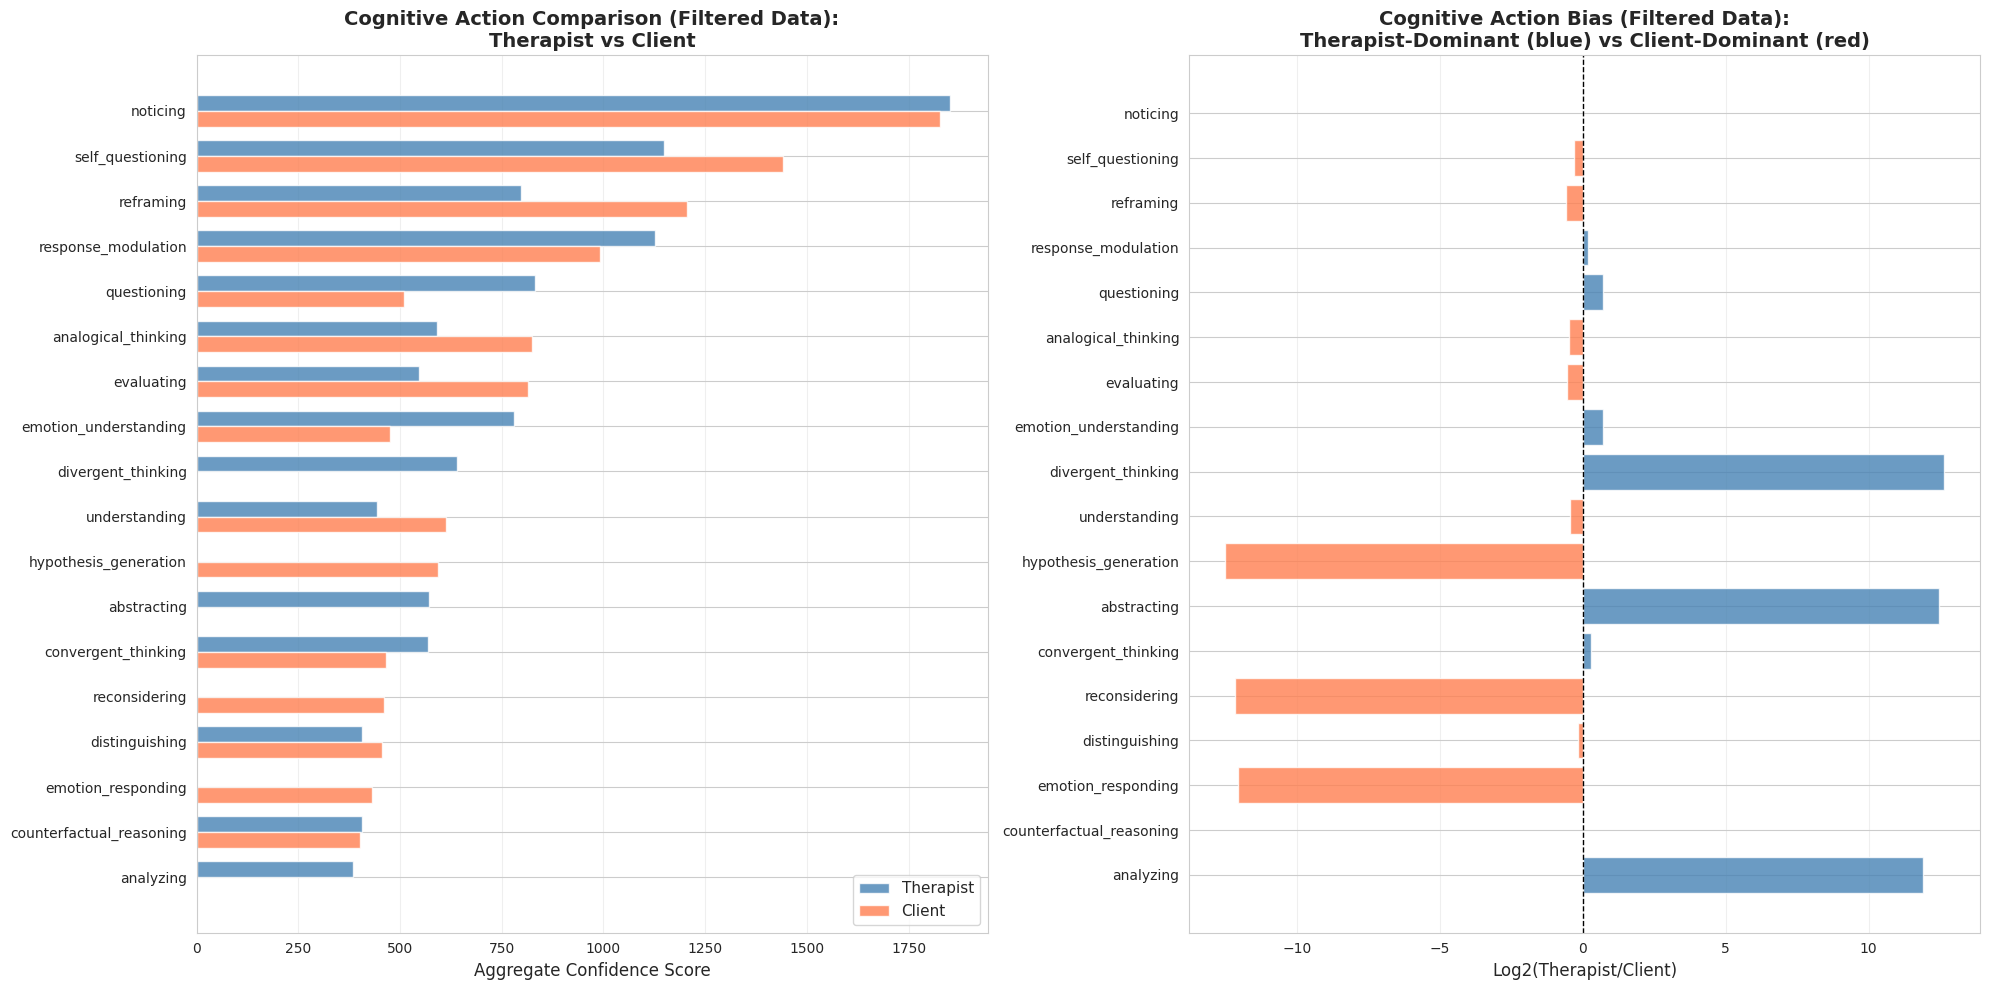

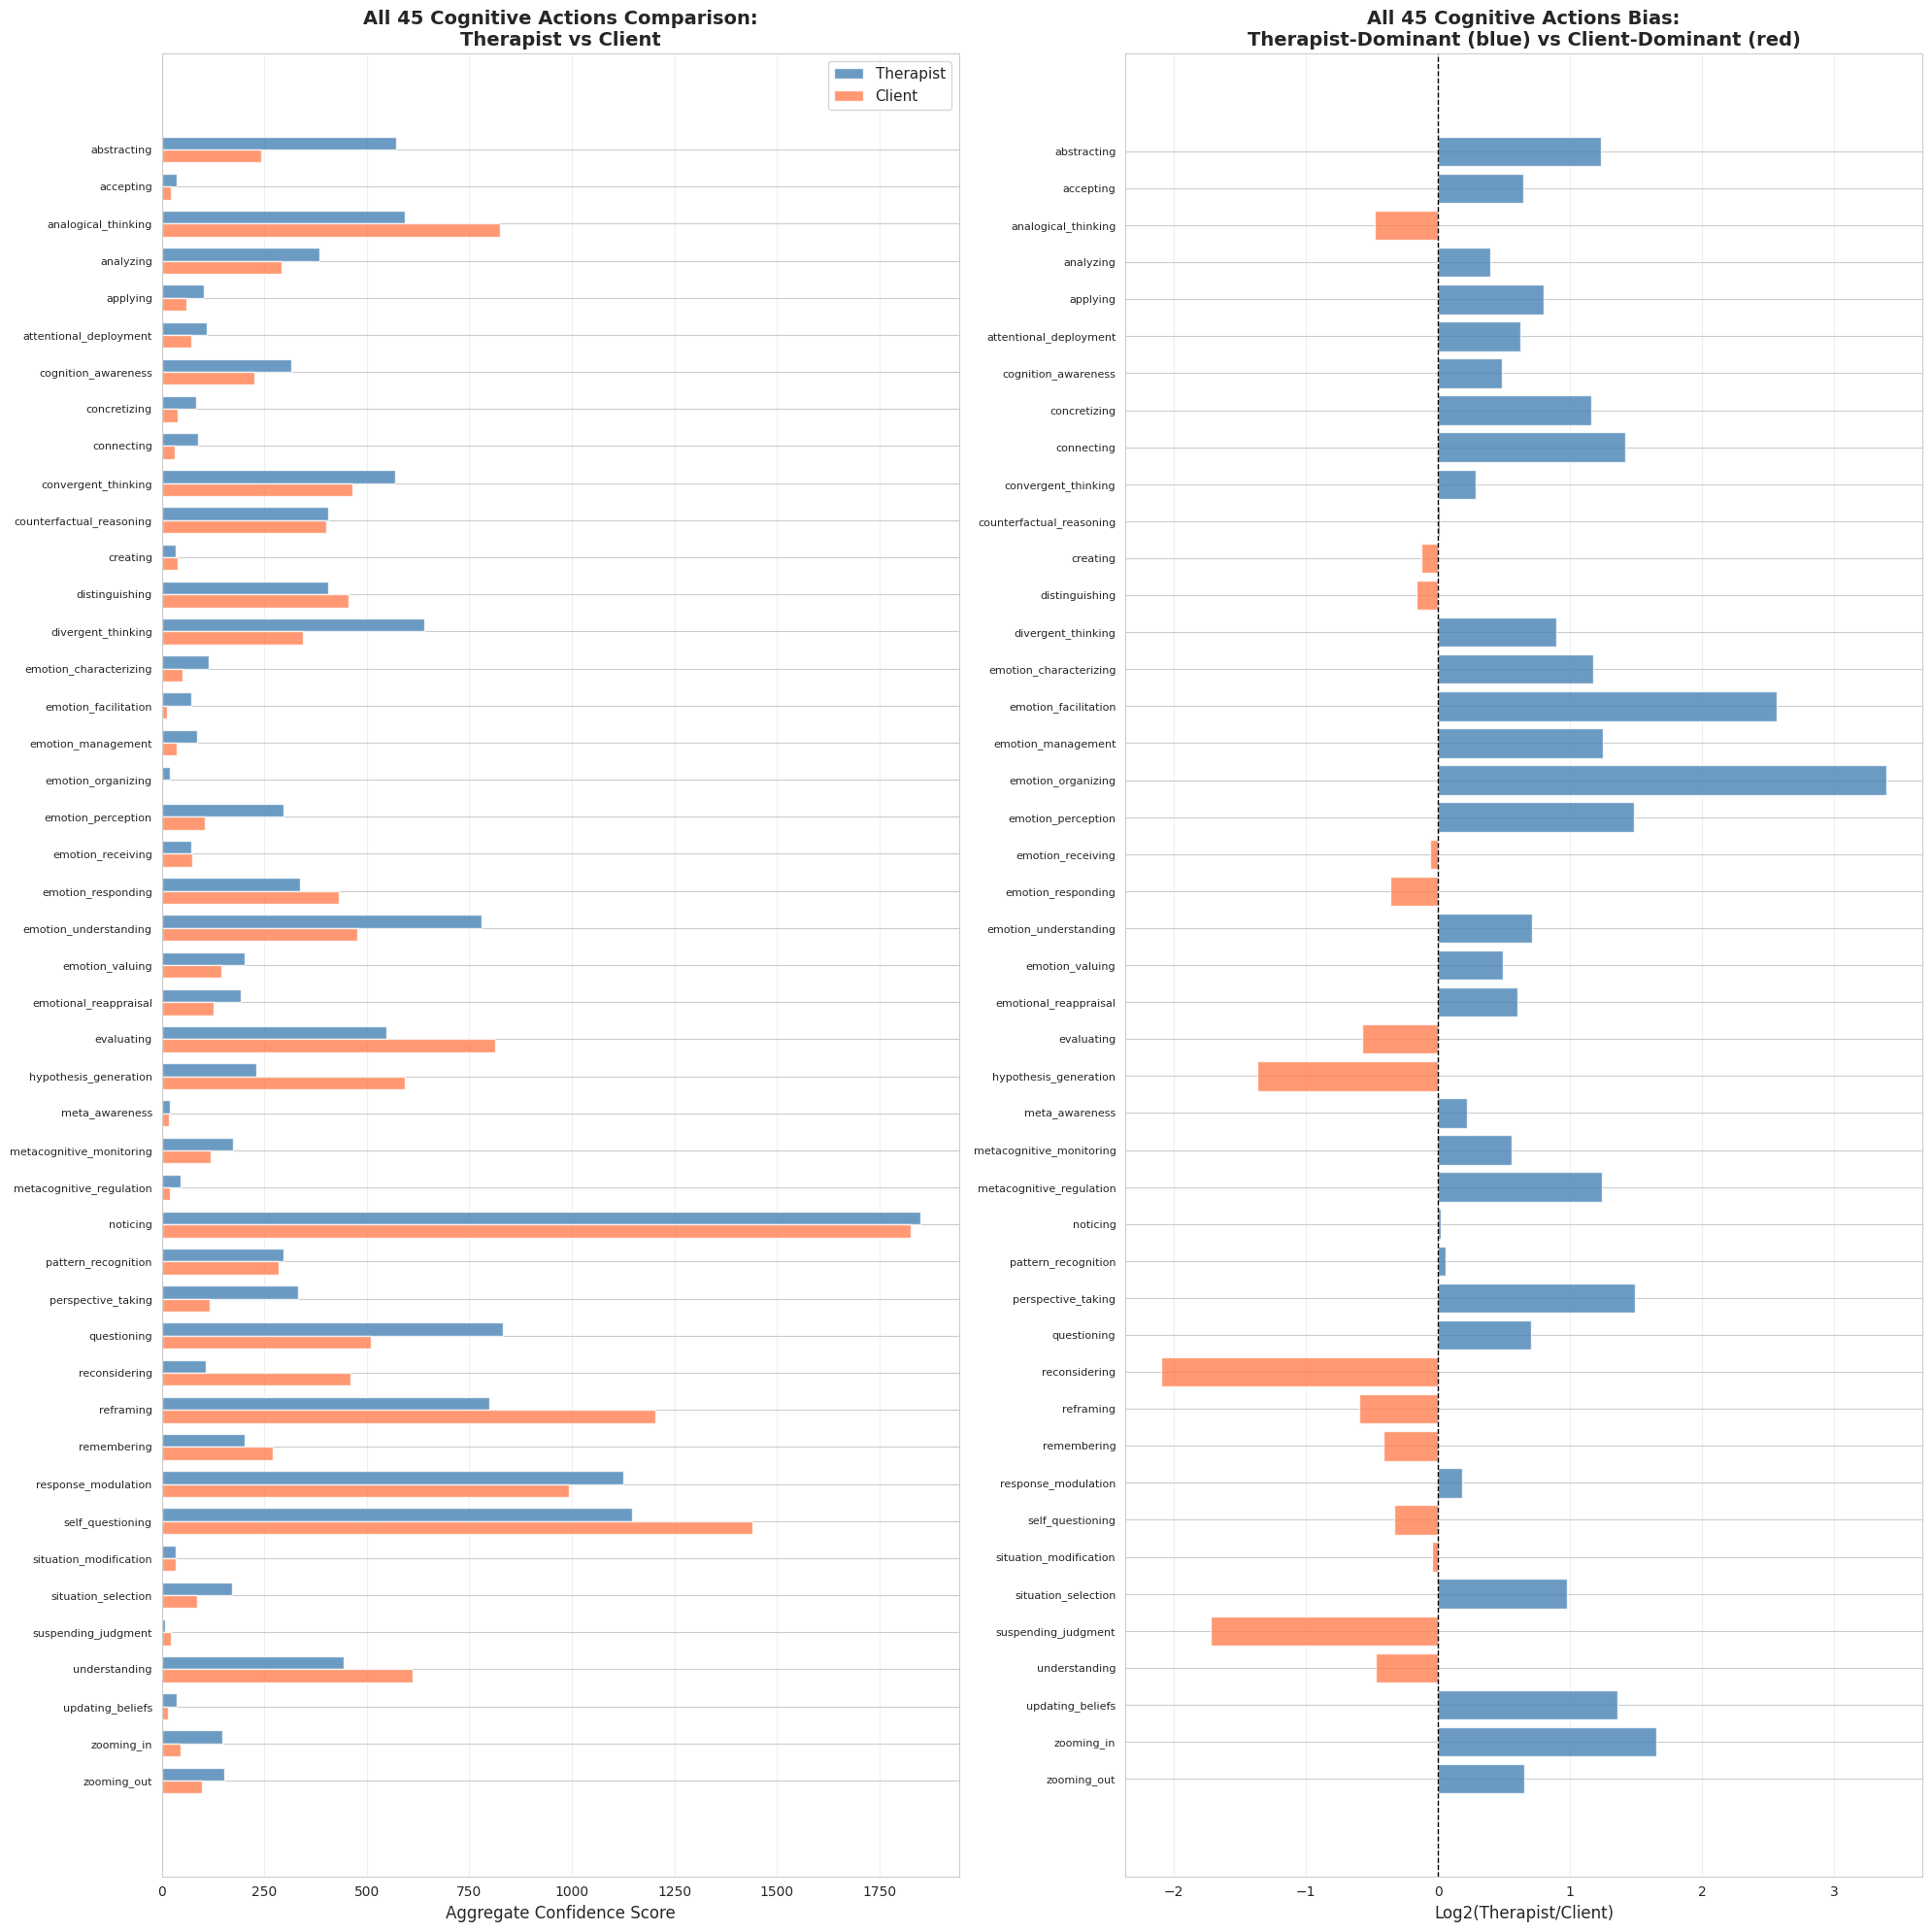

✅ Visualization saved: output/analysis_AnnoMI/filtered_viz_1_comparison.png


In [20]:
# Get top actions
top_therapist = dict(therapist_actions.most_common(15))
top_client = dict(client_actions.most_common(15))

# Combine and get unique actions
all_actions = sorted(
    set(list(top_therapist.keys()) + list(top_client.keys())),
    key=lambda x: max(top_therapist.get(x, 0), top_client.get(x, 0)),
    reverse=True
)

therapist_scores = [top_therapist.get(a, 0) for a in all_actions]
client_scores = [top_client.get(a, 0) for a in all_actions]

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Plot 1: Comparison bar chart
x = np.arange(len(all_actions))
width = 0.35

axes[0].barh(x - width/2, therapist_scores, width, label='Therapist', color='steelblue', alpha=0.8)
axes[0].barh(x + width/2, client_scores, width, label='Client', color='coral', alpha=0.8)
axes[0].set_yticks(x)
axes[0].set_yticklabels(all_actions, fontsize=10)
axes[0].set_xlabel('Aggregate Confidence Score', fontsize=12)
axes[0].set_title('Cognitive Action Comparison (Filtered Data):\nTherapist vs Client', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Plot 2: Ratio comparison
ratios = []
for action in all_actions:
    t_score = top_therapist.get(action, 0.1)
    c_score = top_client.get(action, 0.1)
    ratio = np.log2(t_score / c_score) if c_score > 0 else 0
    ratios.append(ratio)

colors = ['steelblue' if r > 0 else 'coral' for r in ratios]
axes[1].barh(range(len(all_actions)), ratios, color=colors, alpha=0.8)
axes[1].set_yticks(range(len(all_actions)))
axes[1].set_yticklabels(all_actions, fontsize=10)
axes[1].set_xlabel('Log2(Therapist/Client)', fontsize=12)
axes[1].set_title('Cognitive Action Bias (Filtered Data):\nTherapist-Dominant (blue) vs Client-Dominant (red)', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
# Modify the visualization to show all 45 cognitive actions instead of just top 15
# Get all unique actions from both therapist and client
all_unique_actions = sorted(set(
    action for actions in df_filtered['action_names'] for action in actions
))

# Calculate scores for all actions
therapist_all_scores = [therapist_actions.get(a, 0) for a in all_unique_actions]
client_all_scores = [client_actions.get(a, 0) for a in all_unique_actions]

# Create figure with larger size to accommodate all 45 actions
fig, axes = plt.subplots(1, 2, figsize=(20, 20))  # Increased height for all actions

# Plot 1: Comparison bar chart for all actions
x = np.arange(len(all_unique_actions))
width = 0.35

axes[0].barh(x - width/2, therapist_all_scores, width, label='Therapist', color='steelblue', alpha=0.8)
axes[0].barh(x + width/2, client_all_scores, width, label='Client', color='coral', alpha=0.8)
axes[0].set_yticks(x)
axes[0].set_yticklabels(all_unique_actions, fontsize=8)  # Smaller font for readability
axes[0].set_xlabel('Aggregate Confidence Score', fontsize=12)
axes[0].set_title('All 45 Cognitive Actions Comparison:\nTherapist vs Client', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='x')
axes[0].invert_yaxis()

# Plot 2: Ratio comparison for all actions
ratios_all = []
for action in all_unique_actions:
    t_score = therapist_actions.get(action, 0.1)
    c_score = client_actions.get(action, 0.1)
    ratio = np.log2(t_score / c_score) if c_score > 0 else 0
    ratios_all.append(ratio)

colors_all = ['steelblue' if r > 0 else 'coral' for r in ratios_all]
axes[1].barh(range(len(all_unique_actions)), ratios_all, color=colors_all, alpha=0.8)
axes[1].set_yticks(range(len(all_unique_actions)))
axes[1].set_yticklabels(all_unique_actions, fontsize=8)  # Smaller font for readability
axes[1].set_xlabel('Log2(Therapist/Client)', fontsize=12)
axes[1].set_title('All 45 Cognitive Actions Bias:\nTherapist-Dominant (blue) vs Client-Dominant (red)', fontsize=14, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/filtered_viz_1_comparison_all_actions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/filtered_viz_1_comparison.png")

## 6️⃣ Analysis 2: Cognitive Action Co-occurrence

Which cognitive actions tend to appear together in the same utterance?

In [9]:
# Calculate co-occurrence matrix
from scipy.sparse import lil_matrix
from sklearn.preprocessing import normalize

# Get all unique actions
all_action_names = sorted(set(
    action for actions in df_filtered['action_names'] for action in actions
))
action_to_idx = {action: i for i, action in enumerate(all_action_names)}
n_actions = len(all_action_names)

print(f"📊 Computing co-occurrence matrix for {n_actions} cognitive actions...")

# Build co-occurrence matrix
cooccurrence = np.zeros((n_actions, n_actions))

for actions in df_filtered['action_names']:
    if len(actions) > 1:
        for action1, action2 in combinations(actions, 2):
            idx1 = action_to_idx[action1]
            idx2 = action_to_idx[action2]
            cooccurrence[idx1, idx2] += 1
            cooccurrence[idx2, idx1] += 1

# Find top co-occurrences
cooccurrence_pairs = []
for i in range(n_actions):
    for j in range(i+1, n_actions):
        if cooccurrence[i, j] > 0:
            cooccurrence_pairs.append((
                all_action_names[i],
                all_action_names[j],
                cooccurrence[i, j]
            ))

cooccurrence_pairs.sort(key=lambda x: x[2], reverse=True)

print("\n" + "="*80)
print("TOP 30 COGNITIVE ACTION CO-OCCURRENCES")
print("="*80)
for i, (action1, action2, count) in enumerate(cooccurrence_pairs[:30], 1):
    print(f"{i:2d}. {action1:25s} <-> {action2:25s} ({int(count):4d} times)")

# Save for later use
cooccurrence_df = pd.DataFrame(cooccurrence_pairs, columns=['action1', 'action2', 'count'])
cooccurrence_df.to_csv('output/analysis_AnnoMI/cooccurrence_matrix.csv', index=False)
print("\n✅ Co-occurrence matrix saved to: output/analysis_AnnoMI/cooccurrence_matrix.csv")

📊 Computing co-occurrence matrix for 45 cognitive actions...

TOP 30 COGNITIVE ACTION CO-OCCURRENCES
 1. reframing                 <-> self_questioning          (1350 times)
 2. noticing                  <-> self_questioning          (1307 times)
 3. noticing                  <-> response_modulation       (1109 times)
 4. noticing                  <-> reframing                 (1032 times)
 5. response_modulation       <-> self_questioning          ( 788 times)
 6. emotion_understanding     <-> noticing                  ( 706 times)
 7. analogical_thinking       <-> noticing                  ( 698 times)
 8. evaluating                <-> self_questioning          ( 679 times)
 9. questioning               <-> self_questioning          ( 646 times)
10. evaluating                <-> reframing                 ( 622 times)
11. evaluating                <-> noticing                  ( 608 times)
12. analogical_thinking       <-> self_questioning          ( 602 times)
13. reframing          

## 7️⃣ Visualization: Co-occurrence Network

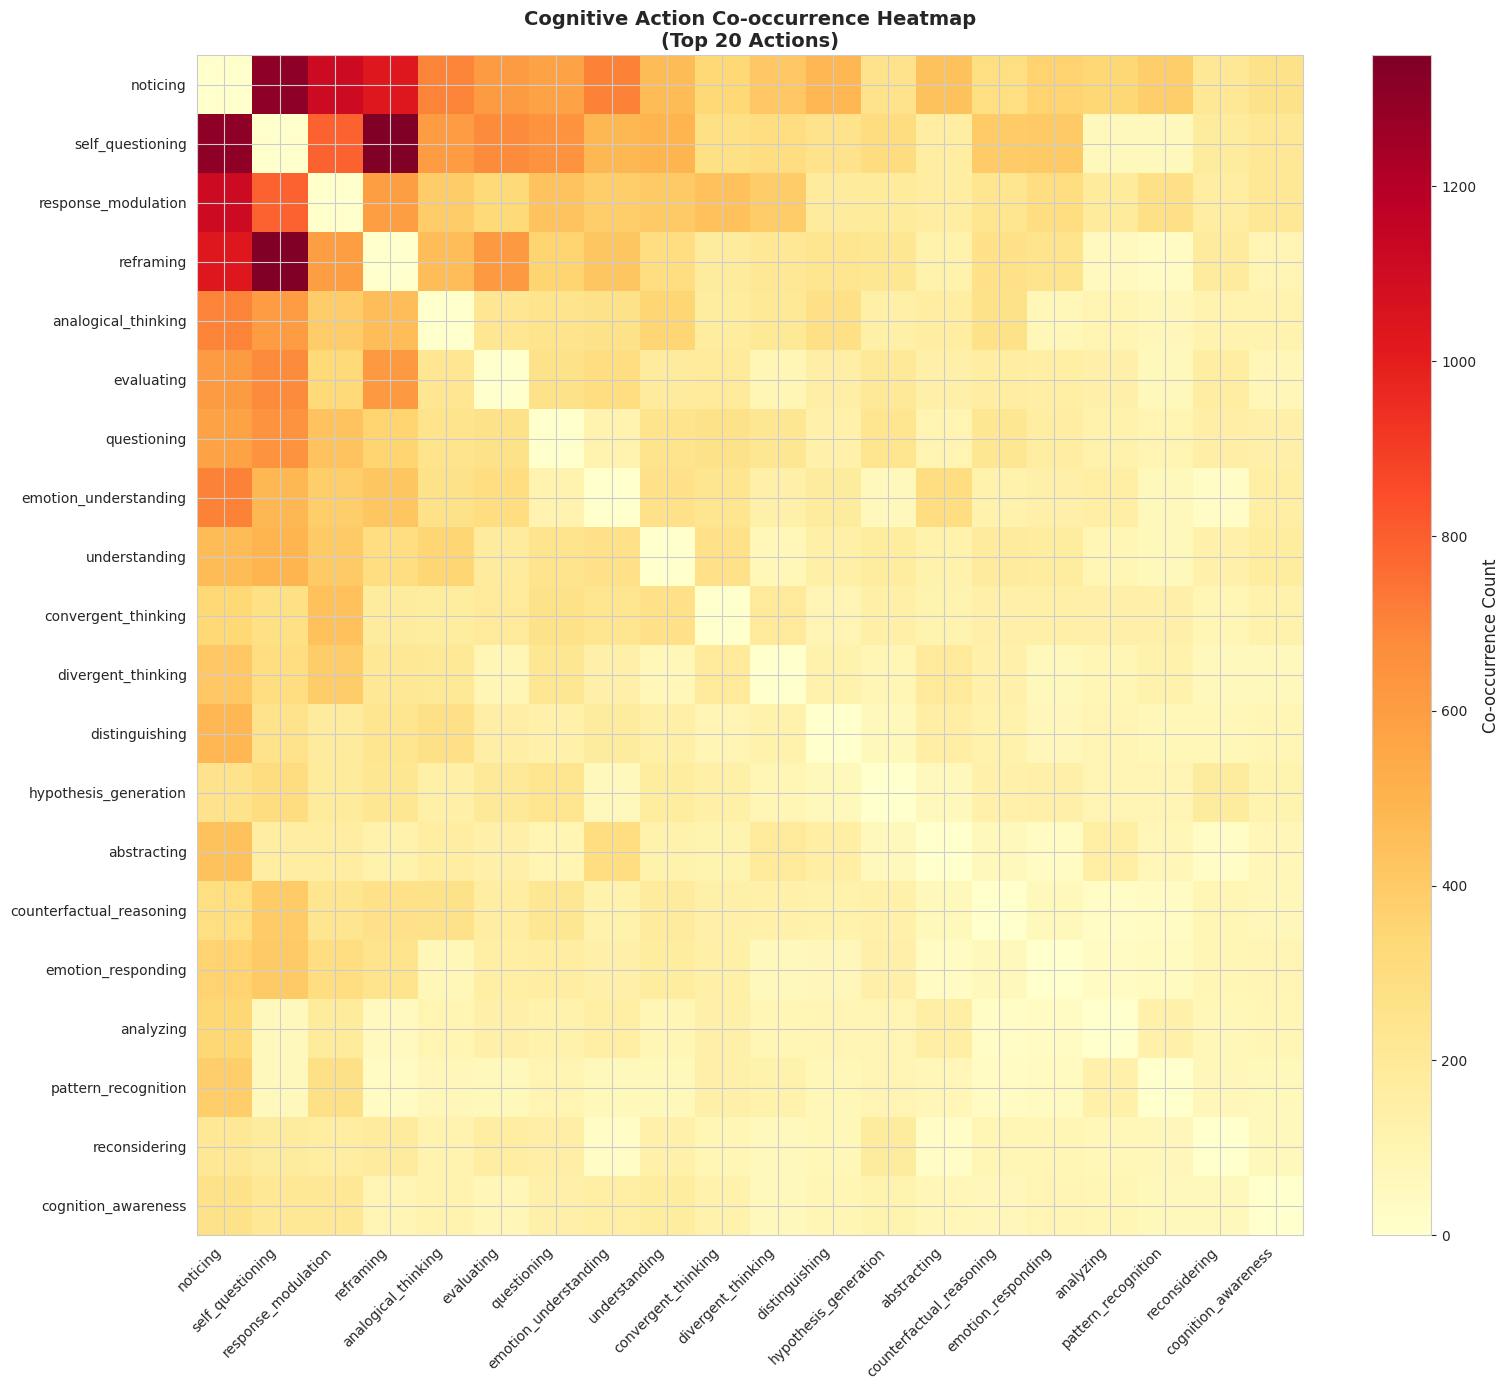

✅ Visualization saved: output/analysis_AnnoMI/filtered_viz_2_cooccurrence.png


In [10]:
# Visualize top co-occurrences as heatmap
# Select top 20 most frequent actions
combined_actions = therapist_actions + client_actions
top_20_actions = [action for action, _ in combined_actions.most_common(20)]

# Create submatrix
top_20_idx = [action_to_idx[action] for action in top_20_actions]
cooccurrence_top20 = cooccurrence[np.ix_(top_20_idx, top_20_idx)]

# Plot heatmap
fig, ax = plt.subplots(figsize=(16, 14))
im = ax.imshow(cooccurrence_top20, cmap='YlOrRd', aspect='auto')

# Set ticks
ax.set_xticks(range(len(top_20_actions)))
ax.set_yticks(range(len(top_20_actions)))
ax.set_xticklabels(top_20_actions, rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(top_20_actions, fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Co-occurrence Count', fontsize=12)

ax.set_title('Cognitive Action Co-occurrence Heatmap\n(Top 20 Actions)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/filtered_viz_2_cooccurrence.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/filtered_viz_2_cooccurrence.png")

## 8️⃣ Analysis 3: Sequential Patterns

What cognitive actions tend to follow each other in conversation?

In [11]:
# Analyze sequential patterns (action A -> action B)
print("🔄 Analyzing sequential patterns...")

# Group by transcript
transitions = Counter()

for transcript_id in df_filtered['transcript_id'].unique():
    transcript_df = df_filtered[df_filtered['transcript_id'] == transcript_id].sort_values('utterance_id')
    
    for i in range(len(transcript_df) - 1):
        current_actions = transcript_df.iloc[i]['action_names']
        next_actions = transcript_df.iloc[i+1]['action_names']
        
        # Count transitions
        for curr_action in current_actions:
            for next_action in next_actions:
                transitions[(curr_action, next_action)] += 1

print("\n" + "="*80)
print("TOP 30 SEQUENTIAL PATTERNS (Action A -> Action B)")
print("="*80)

for i, ((action1, action2), count) in enumerate(transitions.most_common(30), 1):
    print(f"{i:2d}. {action1:25s} -> {action2:25s} ({count:4d} times)")

# Save transitions
transitions_df = pd.DataFrame(
    [(a1, a2, count) for (a1, a2), count in transitions.items()],
    columns=['action_from', 'action_to', 'count']
)
transitions_df.to_csv('output/analysis_AnnoMI/sequential_transitions.csv', index=False)
print("\n✅ Sequential transitions saved to: output/analysis_AnnoMI/sequential_transitions.csv")

🔄 Analyzing sequential patterns...

TOP 30 SEQUENTIAL PATTERNS (Action A -> Action B)
 1. noticing                  -> noticing                  (1915 times)
 2. self_questioning          -> noticing                  (1313 times)
 3. noticing                  -> self_questioning          (1281 times)
 4. response_modulation       -> noticing                  (1077 times)
 5. noticing                  -> response_modulation       (1026 times)
 6. reframing                 -> noticing                  ( 990 times)
 7. self_questioning          -> self_questioning          ( 972 times)
 8. noticing                  -> reframing                 ( 970 times)
 9. response_modulation       -> self_questioning          ( 823 times)
10. self_questioning          -> response_modulation       ( 784 times)
11. response_modulation       -> response_modulation       ( 753 times)
12. reframing                 -> self_questioning          ( 741 times)
13. self_questioning          -> reframing        

## 9️⃣ Analysis 4: MI Quality Correlation

How do cognitive actions differ between high and low quality MI sessions?

In [12]:
# Separate by MI quality
print("🎯 Analyzing cognitive actions by MI quality...")

high_quality = df_filtered[df_filtered['mi_quality'] == 'high']
low_quality = df_filtered[df_filtered['mi_quality'] == 'low']

print(f"\n📊 Dataset split:")
print(f"   High quality: {len(high_quality)} utterances ({len(high_quality)/len(df_filtered)*100:.1f}%)")
print(f"   Low quality: {len(low_quality)} utterances ({len(low_quality)/len(df_filtered)*100:.1f}%)")

# Count actions by quality
high_quality_actions = Counter()
low_quality_actions = Counter()

for _, row in high_quality.iterrows():
    for action_data in row['active_actions']:
        high_quality_actions[action_data['action']] += action_data['confidence']

for _, row in low_quality.iterrows():
    for action_data in row['active_actions']:
        low_quality_actions[action_data['action']] += action_data['confidence']

print("\n" + "="*80)
print("HIGH QUALITY MI SESSIONS - TOP 15 ACTIONS")
print("="*80)
for action, score in high_quality_actions.most_common(15):
    bar = "█" * int(score / 10)
    print(f"{action:35s} {score:7.2f} {bar}")

print("\n" + "="*80)
print("LOW QUALITY MI SESSIONS - TOP 15 ACTIONS")
print("="*80)
for action, score in low_quality_actions.most_common(15):
    bar = "█" * int(score / 10)
    print(f"{action:35s} {score:7.2f} {bar}")

🎯 Analyzing cognitive actions by MI quality...

📊 Dataset split:
   High quality: 6671 utterances (90.5%)
   Low quality: 701 utterances (9.5%)

HIGH QUALITY MI SESSIONS - TOP 15 ACTIONS
noticing                            3324.47 ████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
self_questioning                    2375.56 █████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████
response_modulation                 1858.88 ██████████████████████████████████████████████████████████████████████████████████████████████████████████████

## 🔟 Visualization: MI Quality Comparison

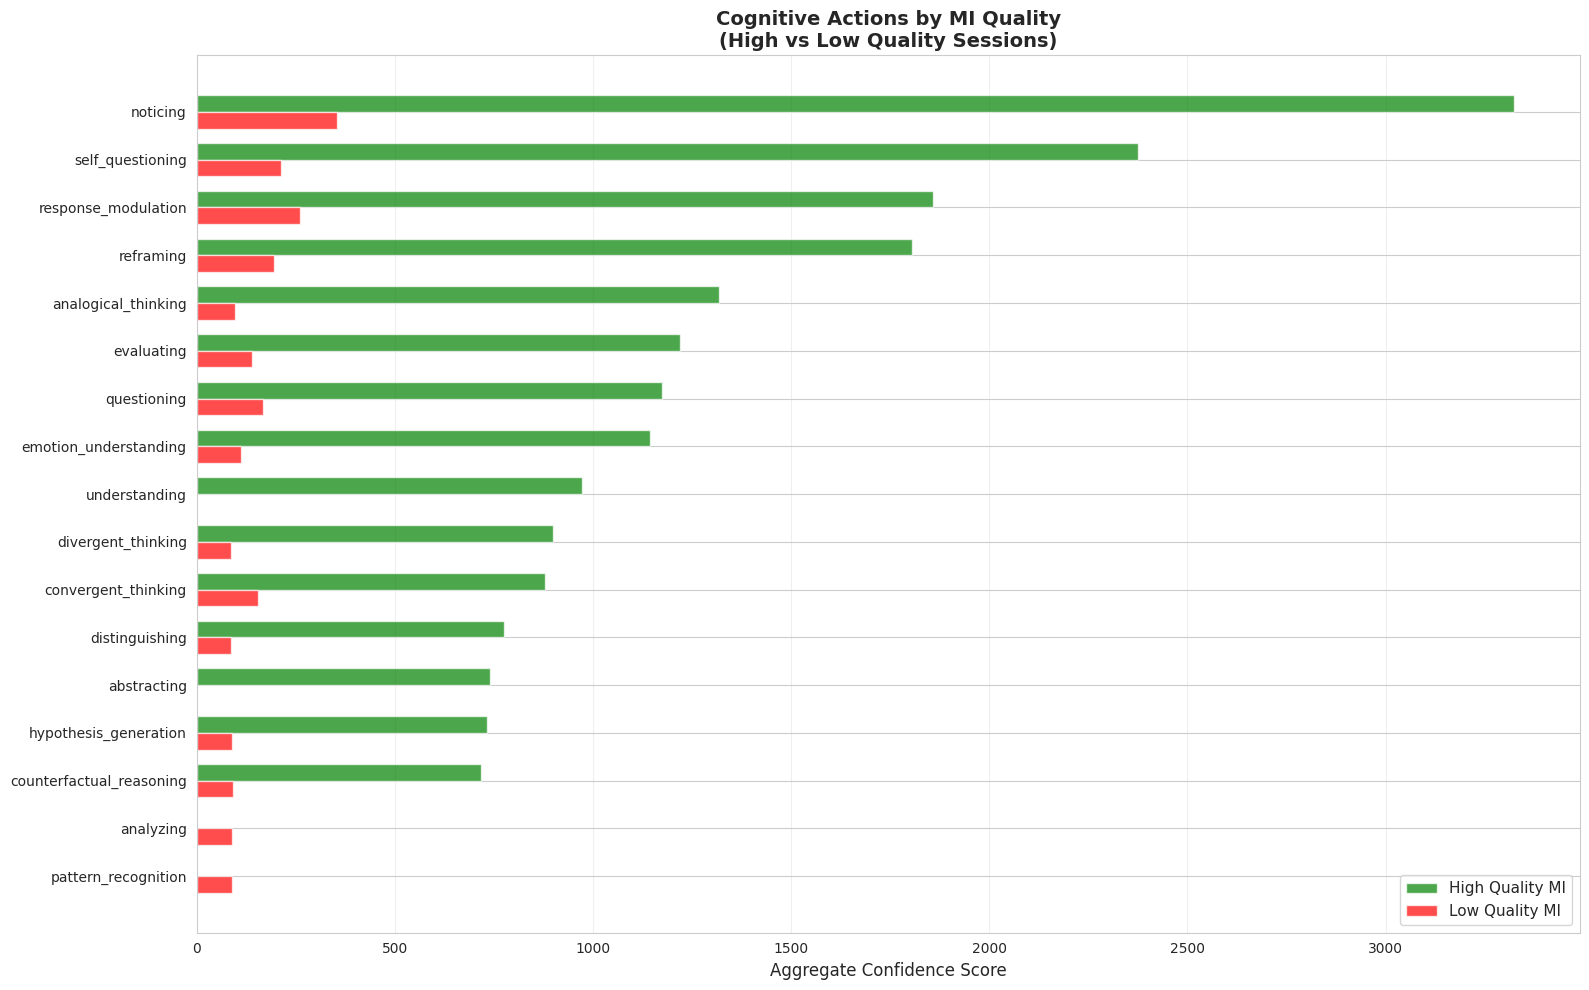

✅ Visualization saved: output/analysis_AnnoMI/filtered_viz_3_mi_quality.png


In [13]:
# Visualize MI quality differences
top_high = dict(high_quality_actions.most_common(15))
top_low = dict(low_quality_actions.most_common(15))

# Combine and get unique actions
all_actions_quality = sorted(
    set(list(top_high.keys()) + list(top_low.keys())),
    key=lambda x: max(top_high.get(x, 0), top_low.get(x, 0)),
    reverse=True
)

high_scores = [top_high.get(a, 0) for a in all_actions_quality]
low_scores = [top_low.get(a, 0) for a in all_actions_quality]

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

x = np.arange(len(all_actions_quality))
width = 0.35

ax.barh(x - width/2, high_scores, width, label='High Quality MI', color='green', alpha=0.7)
ax.barh(x + width/2, low_scores, width, label='Low Quality MI', color='red', alpha=0.7)
ax.set_yticks(x)
ax.set_yticklabels(all_actions_quality, fontsize=10)
ax.set_xlabel('Aggregate Confidence Score', fontsize=12)
ax.set_title('Cognitive Actions by MI Quality\n(High vs Low Quality Sessions)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/filtered_viz_3_mi_quality.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/filtered_viz_3_mi_quality.png")

## 1️⃣1️⃣ Analysis 5: Therapist Behavior Breakdown

Analyze cognitive actions by therapist behavior type

In [14]:
# Filter therapist utterances only
therapist_df = df_filtered[df_filtered['interlocutor'] == 'therapist'].copy()

# Get behavior types
behavior_types = therapist_df['main_therapist_behaviour'].dropna().unique()

print("👨‍⚕️ Therapist Behavior Types:")
for behavior in sorted(behavior_types):
    count = len(therapist_df[therapist_df['main_therapist_behaviour'] == behavior])
    print(f"   {behavior:30s}: {count:4d} utterances")

# Analyze top behaviors
behavior_actions = {}

for behavior in behavior_types:
    behavior_df = therapist_df[therapist_df['main_therapist_behaviour'] == behavior]
    actions = Counter()
    
    for _, row in behavior_df.iterrows():
        for action_data in row['active_actions']:
            actions[action_data['action']] += action_data['confidence']
    
    behavior_actions[behavior] = actions

# Display top actions for each behavior type
print("\n" + "="*80)
print("TOP COGNITIVE ACTIONS BY THERAPIST BEHAVIOR")
print("="*80)

for behavior in sorted(behavior_types):
    print(f"\n{behavior.upper()}:")
    print("-" * 80)
    for action, score in behavior_actions[behavior].most_common(10):
        print(f"   {action:30s} {score:7.2f}")

👨‍⚕️ Therapist Behavior Types:
   other                         :  507 utterances
   question                      : 1356 utterances
   reflection                    : 1276 utterances
   therapist_input               :  609 utterances

TOP COGNITIVE ACTIONS BY THERAPIST BEHAVIOR

OTHER:
--------------------------------------------------------------------------------
   noticing                        335.99
   self_questioning                296.01
   reframing                       264.12
   response_modulation             157.05
   emotion_understanding           145.98
   evaluating                      114.94
   emotion_responding               84.27
   analogical_thinking              74.00
   understanding                    57.91
   abstracting                      54.00

QUESTION:
--------------------------------------------------------------------------------
   noticing                        581.02
   questioning                     546.27
   self_questioning                

## 1️⃣2️⃣ Visualization: Distribution of Active Actions per Utterance

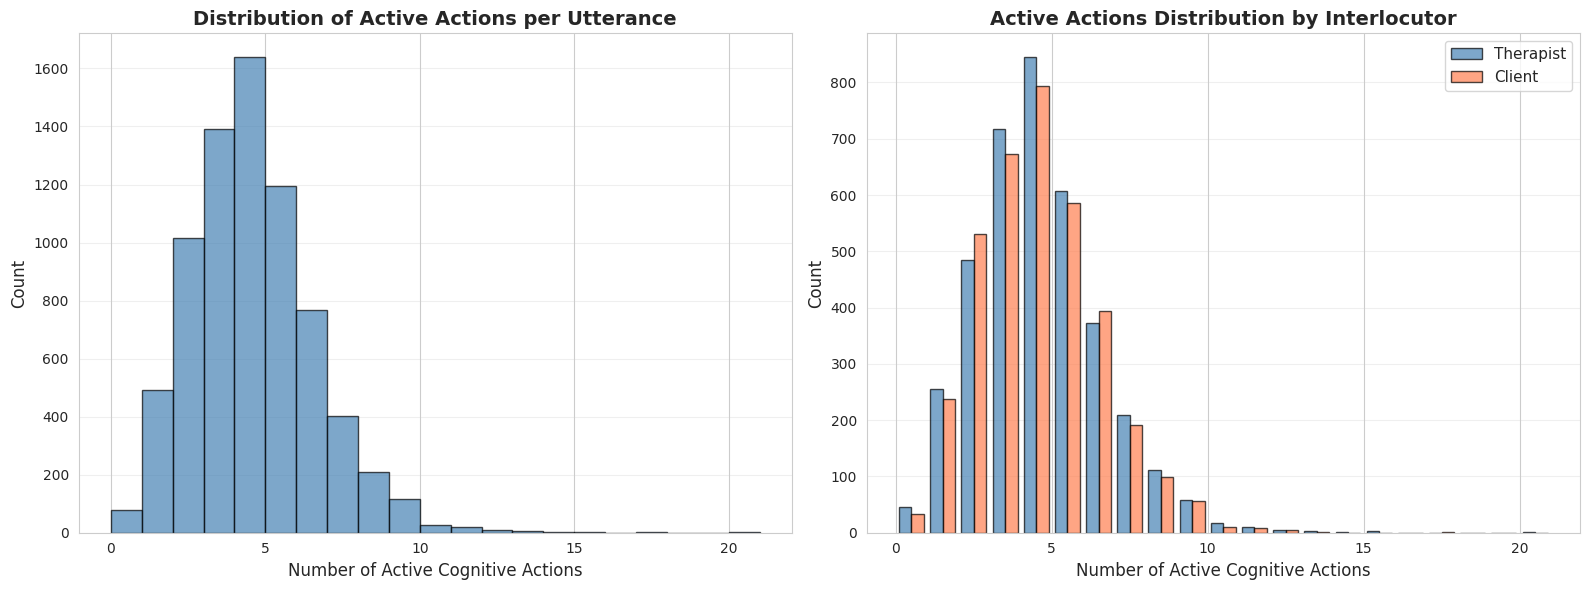

✅ Visualization saved: output/analysis_AnnoMI/filtered_viz_4_distribution.png


In [15]:
# Visualize distribution of number of active actions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(df_filtered['num_active_actions'], bins=range(0, df_filtered['num_active_actions'].max()+2), 
             color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Active Cognitive Actions', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Active Actions per Utterance', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')

# By interlocutor
therapist_counts = df_filtered[df_filtered['interlocutor'] == 'therapist']['num_active_actions']
client_counts = df_filtered[df_filtered['interlocutor'] == 'client']['num_active_actions']

axes[1].hist([therapist_counts, client_counts], bins=range(0, df_filtered['num_active_actions'].max()+2),
             label=['Therapist', 'Client'], color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Number of Active Cognitive Actions', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Active Actions Distribution by Interlocutor', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/filtered_viz_4_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/filtered_viz_4_distribution.png")

## 1️⃣3️⃣ Summary Statistics

In [16]:
print("="*80)
print("COMPREHENSIVE SUMMARY STATISTICS (FILTERED DATA)")
print("="*80)

print(f"\n📊 Dataset:")
print(f"   Total utterances (filtered): {len(df_filtered)}")
print(f"   Removed short utterances: {len(df) - len(df_filtered)} ({(len(df) - len(df_filtered))/len(df)*100:.1f}%)")
print(f"   Transcripts: {df_filtered['transcript_id'].nunique()}")
print(f"   Topics: {df_filtered['topic'].nunique()}")
print(f"   Mean utterance length: {df_filtered['utterance_length'].mean():.1f} characters")

print(f"\n🧠 Cognitive Actions:")
print(f"   Unique cognitive actions detected: {len(all_action_names)}")
print(f"   Mean actions per utterance: {df_filtered['num_active_actions'].mean():.2f}")
print(f"   Median actions per utterance: {df_filtered['num_active_actions'].median():.1f}")
print(f"   Utterances with actions: {len(df_filtered[df_filtered['num_active_actions'] > 0])} ({len(df_filtered[df_filtered['num_active_actions'] > 0])/len(df_filtered)*100:.1f}%)")

print(f"\n👥 By Interlocutor:")
print(f"   Therapist utterances: {len(df_filtered[df_filtered['interlocutor'] == 'therapist'])}")
print(f"   Client utterances: {len(df_filtered[df_filtered['interlocutor'] == 'client'])}")
print(f"   Therapist avg actions/utterance: {df_filtered[df_filtered['interlocutor'] == 'therapist']['num_active_actions'].mean():.2f}")
print(f"   Client avg actions/utterance: {df_filtered[df_filtered['interlocutor'] == 'client']['num_active_actions'].mean():.2f}")

print(f"\n🎯 MI Quality:")
print(f"   High quality: {len(df_filtered[df_filtered['mi_quality'] == 'high'])} ({len(df_filtered[df_filtered['mi_quality'] == 'high'])/len(df_filtered)*100:.1f}%)")
print(f"   Low quality: {len(df_filtered[df_filtered['mi_quality'] == 'low'])} ({len(df_filtered[df_filtered['mi_quality'] == 'low'])/len(df_filtered)*100:.1f}%)")

print(f"\n📈 Top Findings:")
print(f"   Most common therapist action: {therapist_actions.most_common(1)[0][0]}")
print(f"   Most common client action: {client_actions.most_common(1)[0][0]}")
print(f"   Most common co-occurrence: {cooccurrence_pairs[0][0]} + {cooccurrence_pairs[0][1]}")
print(f"   Most common transition: {transitions.most_common(1)[0][0][0]} -> {transitions.most_common(1)[0][0][1]}")

print("\n" + "="*80)
print("✅ Analysis complete!")
print("="*80)

COMPREHENSIVE SUMMARY STATISTICS (FILTERED DATA)

📊 Dataset:
   Total utterances (filtered): 7372
   Removed short utterances: 2327 (24.0%)
   Transcripts: 133
   Topics: 44
   Mean utterance length: 106.2 characters

🧠 Cognitive Actions:
   Unique cognitive actions detected: 45
   Mean actions per utterance: 4.09
   Median actions per utterance: 4.0
   Utterances with actions: 7293 (98.9%)

👥 By Interlocutor:
   Therapist utterances: 3748
   Client utterances: 3624
   Therapist avg actions/utterance: 4.11
   Client avg actions/utterance: 4.07

🎯 MI Quality:
   High quality: 6671 (90.5%)
   Low quality: 701 (9.5%)

📈 Top Findings:
   Most common therapist action: noticing
   Most common client action: noticing
   Most common co-occurrence: reframing + self_questioning
   Most common transition: noticing -> noticing

✅ Analysis complete!


## 1️⃣4️⃣ Export Summary Report

In [17]:
# Create summary report
summary = {
    'dataset': {
        'total_utterances_original': len(df),
        'total_utterances_filtered': len(df_filtered),
        'removed_utterances': len(df) - len(df_filtered),
        'min_length_threshold': MIN_LENGTH,
        'transcripts': int(df_filtered['transcript_id'].nunique()),
        'topics': int(df_filtered['topic'].nunique()),
        'mean_utterance_length': float(df_filtered['utterance_length'].mean()),
    },
    'cognitive_actions': {
        'unique_actions': len(all_action_names),
        'mean_per_utterance': float(df_filtered['num_active_actions'].mean()),
        'median_per_utterance': float(df_filtered['num_active_actions'].median()),
    },
    'top_therapist_actions': dict(therapist_actions.most_common(10)),
    'top_client_actions': dict(client_actions.most_common(10)),
    'top_cooccurrences': [(a1, a2, int(c)) for a1, a2, c in cooccurrence_pairs[:10]],
    'top_transitions': [(a1, a2, int(c)) for (a1, a2), c in transitions.most_common(10)],
    'high_quality_top_actions': dict(high_quality_actions.most_common(10)),
    'low_quality_top_actions': dict(low_quality_actions.most_common(10)),
}

# Save summary
with open('output/analysis_AnnoMI/filtered_summary_report.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("✅ Summary report saved to: output/analysis_AnnoMI/filtered_summary_report.json")

✅ Summary report saved to: output/analysis_AnnoMI/filtered_summary_report.json
